In [ ]:
import numpy as np
import pandas as pd
import os
from random import shuffle
import cv2
import time
import seaborn as sns
import matplotlib.pyplot as plt
import glob as gb
%matplotlib inline


In [ ]:
import keras
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D,GlobalMaxPooling2D,AveragePooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout,Concatenate
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.regularizers import l2
from keras.losses import categorical_crossentropy
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold 

In [ ]:
WIDTH=224
HEIGHT=224

In [ ]:
train_image = "dataset/train"
test_image = "dataset/test"


print(train_image)
print(test_image)

dataset/train
dataset/test


In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   zoom_range = 0.2,
                                   rotation_range=15,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)


In [ ]:
from keras import backend as K
def precision_threshold(threshold = 0.5):
    def precision(y_true, y_pred):
        threshold_value = threshold
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(y_pred)
        precision_ratio = true_positives / (predicted_positives + K.epsilon())
        return precision_ratio
    return precision
def recall_threshold(threshold = 0.5):
    def recall(y_true, y_pred):
        threshold_value = threshold
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.clip(y_true, 0, 1))
        recall_ratio = true_positives / (possible_positives + K.epsilon())
        return recall_ratio
    return recall
def fbeta_score_threshold(beta = 1, threshold = 0.5):
    def fbeta_score(y_true, y_pred):
        threshold_value = threshold
        beta_value = beta
        p = precision_threshold(threshold_value)(y_true, y_pred)
        r = recall_threshold(threshold_value)(y_true, y_pred)
        bb = beta_value ** 2
        fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
        return fbeta_score
    return fbeta_score

In [ ]:
#hybrid model
IMAGE_SIZE=(224,224,3)
#vgg16 model
vgg16 = VGG16(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)
for layer in vgg16.layers:
    layer._name = layer._name + str('_16')
    layer.trainable = False
    
#vgg19 model
vgg19 = VGG19(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)
for layer in vgg19.layers:
    layer._name = layer._name + str('_19')
    layer.trainable = False
    
#Proposed CNN model
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=IMAGE_SIZE,padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(16,kernel_size= (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(rate=0.2))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(32,kernel_size= (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(rate=0.2))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64,kernel_size= (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(rate=0.2))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128,kernel_size= (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(rate=0.2))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256,kernel_size= (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(rate=0.2))
  

inp = Input(IMAGE_SIZE)
    
vgg16_x = Flatten()(vgg16(inp))
vgg19_x = Flatten()(vgg19(inp))
cnn_x   = Flatten()(model(inp))

x = Concatenate()([vgg16_x, vgg19_x, cnn_x])
x = Dense(512, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(256, activation="relu")(x)
out = Dense(3, activation='softmax')(x)

model = Model(inputs = inp, outputs = out)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
vgg16 (Functional)              (None, 7, 7, 512)    14714688    input_6[0][0]                    
__________________________________________________________________________________________________
vgg19 (Functional)              (None, 7, 7, 512)    20024384    input_6[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 7, 7, 256)    1182736     input_6[0][0]                    
_______________________________________________________________________________________

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cvscores = []
for train, test in kfold.split(train_image):
    opt=Adam(learning_rate=0.001)
    model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=[precision_threshold(threshold = 0.5), 
                       recall_threshold(threshold = 0.5), 
                       fbeta_score_threshold(beta=0.5, threshold = 0.5),
                      'accuracy','AUC',])
    
    train_generator = train_datagen.flow_from_directory(train_image,
                                                 target_size = (224,224),
                                                 batch_size = 16,
                                                 class_mode = 'categorical',
                                                 shuffle=True)

    test_generator = test_datagen.flow_from_directory(test_image,
                                            target_size = (224,224),
                                            batch_size = 16,
                                            class_mode = 'categorical',
                                            shuffle = False)
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')          
    start=time.time()
    history = model.fit_generator(train_generator,
                              validation_data=test_generator,
                              epochs=25,callbacks=[earlystop]) 
    print("training time: %.2f minutes"%((time.time()-start)/60))
    
    scores = model.evaluate(test_generator)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
322/322 [==============================] - 1658s 5s/step - loss: 0.6515 - precision: 0.8490 - recall: 0.8428 - fbeta_score: 0.8477 - accuracy: 0.8466 - auc: 0.9445 - val_loss: 0.2031 - val_precision: 0.9292 - val_recall: 0.9252 - val_fbeta_score: 0.9283 - val_accuracy: 0.9270 - val_auc: 0.9870
Epoch 2/25
322/322 [==============================] - 1633s 5s/step - loss: 0.2477 - precision: 0.9119 - recall: 0.9064 - fbeta_score: 0.9108 - accuracy: 0.9098 - auc: 0.9823 - val_loss: 0.1924 - val_precision: 0.9189 - val_recall: 0.9120 - val_fbeta_score: 0.9174 - val_accuracy: 0.9154 - val_auc: 0.9892
Epoch 3/25
322/322 [==============================] - 1650s 5s/step - loss: 0.2317 - precision: 0.9183 - recall: 0.9105 - fbeta_score: 0.9166 - accuracy: 0.9152 - auc: 0.9836 - val_loss: 0.2292 - val_precision: 0.9065 - val_reca

In [ ]:
test_generator.reset() #Necessary to force it to start from beginning
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=-1)
sum(y_pred==test_generator.classes)/10000


Instructions for updating:
Please use Model.predict, which supports generators.


0.1175

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_generator.classes,y_pred)

array([[103,  10,   3],
       [  0, 314,   3],
       [  0,  97, 758]], dtype=int64)

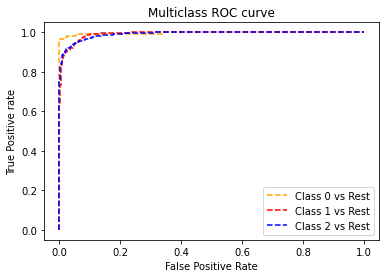

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(test_generator.classes, Y_pred[:,i], pos_label=i)
       
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='red', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);    
